In [ ]:
import os 
import numpy as np 
import cv2
from pdf2image import convert_from_path
import pytesseract
import unicodedata
import re
import pandas as pd
import natsort
import matplotlib.pyplot as plt
import spellchecker
import rapidfuzz
import unidecode 
import tqdm 
from sklearn.decomposition import NMF
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import seaborn as sns 
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'
config = '--oem 2'
spell = spellchecker.SpellChecker(language='fr') # SpellChecker in french

current_dir = os.getcwd()


pd.set_option("display.max_rows", None)      
pd.set_option("display.max_columns", None)   
pd.set_option("display.width", 0)            
pd.set_option("display.max_colwidth", None)  


In [42]:
# Extracts the year from the filename after 'Thèses_'.
def extract_year_from_filename(filename):
    # Regex pattern to match both formats
    match = re.search(r'Theses_(\d{4})(?:_(\d{4}))?_(\d+)_(\d+|blank)(?:\.pdf)?$', filename)
    
    # If no match is found, return None or handle as needed
    if not match:
        return None

    # Extract the year and check if there's a second year
    year = match.group(1)
    second_year = match.group(2)  # This will be None if there's no second year
    start = match.group(3)
    end = match.group(4)

    # If a second year exists, concatenate it with the first year
    if second_year:
        year = f"{year}_{second_year}"

    return (year, int(start), end)

In [ ]:
#Checks if a page is blank 
def is_blank(image, threshold=0.99):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    height = gray.shape[0]
    
    # Crops the 10% at the bottom of the page so that the number of the page doesn't affect our analysis
    cropped_gray = gray[:int(0.9 * height), :]
    
    _, thresh = cv2.threshold(cropped_gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(thresh == 255) / thresh.size
    
    return white_ratio > threshold  # Return true if the page is blank 

In [44]:
# Converts a PDF file into images, saving each page as a PNG.
# # Images are stored in the specified output folder.
def convert_pdf_to_images(pdf_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_path)
    if end_page =='blank' :
        images = images[start_page:] 
    else : 
        end_page = int(end_page)
        images = images[start_page:end_page+1]  

    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f"page_{i+1}.png")
        image.save(image_path, "PNG")

        if is_blank(image):
            break

In [45]:
# Processes all PDFs in the input directory.
# Extracts the year from the filename and creates a subfolder for each year.
# Converts each PDF into images and stores them in the corresponding subfolder.
def process_all_pdfs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the parent directory exists
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(input_dir, filename)  # Full path to PDF
            year, start_page, end_page = extract_year_from_filename(filename)
            if not year or year == "Erreur":  # Skip if invalid year extracted
                continue

            output_folder = os.path.join(output_dir, year)
            os.makedirs(output_folder, exist_ok=True)  # Ensure the subfolder is created
            
            convert_pdf_to_images(pdf_path, output_folder,start_page,end_page)



In [ ]:
# Define the input and output paths relative to the current directory
input_dir = os.path.join(current_dir, '..', 'data', 'pdf_Tables_theses_Paris_1870_1939')  # Relative path to 'lib/data/pdf_Tables_theses_Paris_1870_1939'
output_dir = os.path.join(current_dir, '..', 'data', 'pdfs_en_images_png')  # Output path within 'lib/data/pdfs_en_images_png'

os.makedirs(output_dir, exist_ok = True)

process_all_pdfs(input_dir, output_dir)

FIN DE LA TRANSFORMATION EN PNG DES FICHIERS;
DEBUT DE L'EXTRACTIION ET DU TRAITEMENT DU TEXTE.

























In [ ]:
def detect_all_tome_positions(image):
    data = pytesseract.image_to_data(image, lang='fra', output_type=pytesseract.Output.DICT)
    tome_positions = []

    for i, text in enumerate(data["text"]):
        clean = text.strip().upper()
        if not clean:
            continue
        if clean == "TOME" or re.search(r'\bTOME\s+\w+\b', clean):
            y = data["top"][i]
            h = data["height"][i]
            tome_positions.append((y, h))

    return sorted(tome_positions, key=lambda x: x[0])  # triage by vertical order 


In [ ]:
def split_by_tome_markers(image, positions):
    slices = []
    prev_y = 0

    for y, h in positions:
        cut_y = y + h
        slices.append(image[prev_y:cut_y, :])
        prev_y = cut_y

    # Last segment 
    slices.append(image[prev_y:, :])
    return slices

In [86]:
def extract_columns(image):
    (h, w) = image.shape
    left = image[:, :w//2 - 5]
    right = image[:, 5 + w//2:]    

    left_text = pytesseract.image_to_string(left, lang='fra', config=config)
    right_text = pytesseract.image_to_string(right, lang='fra', config=config)
    return re.sub(r'\d+', '', left_text + " " + right_text)


In [87]:
def process_image(image, first):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    scale_percent = 250 
    width = int(gray.shape[1] * scale_percent / 100)
    height = int(gray.shape[0] * scale_percent / 100)      
    dim = (width, height)
    gray = cv2.resize(gray, dim, interpolation=cv2.INTER_LINEAR)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    gray = cv2.medianBlur(gray, 3)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
    gray = cv2.dilate(gray, kernel, iterations=1)

    if first:
        gray = gray[580:, :]

    tome_positions = detect_all_tome_positions(gray)

    if tome_positions:
        horizontal_slices = split_by_tome_markers(gray, tome_positions)
        full_text = ""

        for i, slice_img in enumerate(horizontal_slices):
            text = extract_columns(slice_img)
            full_text += f"--- Segment {i+1} ---\n{text}\n\n"

        return full_text
    else:
        return extract_columns(gray)
    

In [ ]:
def extract_informations(text, year):

    pattern = re.compile(r"([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇ]{2,})(?: \(([^)]+)\))?\. (.+)?")

    data = []
    current_nom = None
    current_prenom = None
    current_sujet = ""        
    current_year = year             

    lines = text.split("\n")

    for line in lines:
        line = line.strip()  
        
        match = pattern.match(line)  

        if match:
            if current_nom is not None:
                data.append([current_nom, current_prenom, current_sujet.strip(),current_year])

            current_nom = match.group(1)
            current_prenom = match.group(2)
            current_sujet = match.group(3) if match.group(3) else ""
        
        else:
            if current_nom is not None:
                current_sujet += " " + line  

    if current_nom is not None:
        data.append([current_nom, current_prenom, current_sujet.strip(), current_year])

    df_cleaned = pd.DataFrame(data, columns=["Nom", "Prénom", "Sujet","year"])

    return df_cleaned

In [89]:
def process_folder(input_dir,year):
    text = ""  
    df = pd.DataFrame()
  
    
    for image_file in natsort.natsorted(os.listdir(input_dir)):
        image_path = os.path.join(input_dir, image_file)
        image = cv2.imread(image_path)
        if image_file.lower().endswith('.png'): 
            if  image_file == "page_1.png" : 
                first = True 
            else : first = False
            text = text + process_image(image, first)
    df = extract_informations(text,year)
    return df

In [90]:
def remove_accents(text):
    if isinstance(text, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
    return text

In [91]:
def cleanup_up_subject_column(df) :
    df['Nom'] = df['Nom'].astype(str)
    df['Prénom'] = df['Prénom'].astype(str)
    df['Sujet'] = df['Sujet'].astype(str)
    df['Sujet'] = df['Sujet'].str.replace('- ', '', regex=False)
    df['Sujet'] = df['Sujet'].str.replace(r',?\s*\d+\s*', ' ', regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r'\s+', ' ', regex=True).str.strip() 
    df['Sujet'] = df['Sujet'].str.replace(r"([bcdfghjklmnpqrstvwxyz]) (?=[aeiouy])", r"\1", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"[\"'#%&*\[\]{}<>|\\/^¤§°@=+\~`]", "", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"[•●▪■♦◊¤§°@©®™‰¨«»„”“†‡‚‘’]", " ", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\b[a-zA-Z]\b", "", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\b(TOM|TON|H|U|UVIL|co|tu|ot|mw|vf|En|El|N)\b", "", regex=True, flags=re.IGNORECASE)
    df['Sujet'] = df['Sujet'].str.replace(r"\s*[\.,;:!?]\s*", ". ", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\s+", " ", regex=True).str.strip()
    df['Sujet'] = df['Sujet'].apply(remove_accents)
    df['Prénom'] = df['Prénom'].apply(remove_accents).str.lower()


In [92]:
def process_all_folders(input_dir) : 
    df= pd.DataFrame(columns=["Nom", "Prénom", "Sujet", "year"])

    for year_folder in natsort.natsorted(os.listdir(input_dir)):
        year_path = os.path.join(input_dir, year_folder) 
        print(year_folder)        
        if os.path.isdir(year_path):  # Check if it's a directory
            df = pd.concat((df, process_folder(year_path, year_folder)), ignore_index= True)
            cleanup_up_subject_column(df)

    return df

In [93]:
input_dir = os.path.join(current_dir, '..', 'data', 'pdfs_en_images_png')  # Relative path to 'lib/data/pdfs_en_images_png'

df1 = process_all_folders(input_dir)


1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882_1883
1883_1884
1884_1885
1885_1886
1886_1887
1887_1888
1888_1889
1889_1890
1890_1891
1891_1892
1892_1893
1893_1894
1894_1895
1895_1896
1896_1897
1897_1898
1898_1899
1899_1900
1900_1901
1901_1902
1902_1903
1903_1904
1904_1905
1905_1906
1906_1907
1907_1908
1908_1909
1909_1910
1910_1911
1911_1912
1912_1913
1913_1914
1914_1915
1915_1916
1916_1917
1917_1918
1918_1919
1919_1920
1920_1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
.DS_Store


FIN  DE L'EXTRACTION DE TEXTE ET CORRECTIONS MINEURES D'OCR. 
DEBUT DU TRAITEMENT DE TEXTE : 
PRECISION ET CORRECTION DE L'OCR (DICTIONNAIRE FRANCAIS ET MEDICAL)
Corriger les mots faux de l ocrisation a l aide des dictionnaires: 
tu pourrais envisager une correction automatique OCR après reconnaissance (spellchecker français + médical).

Exemples de librairies :

pyspellchecker
fuzzywuzzy pour match flous avec ton francais.txt

Une fois que la correction est faire refaire test de precision


In [ ]:
input_dir = input_dir = os.path.join(current_dir, '..', 'data', 'Dictionnaires')  # Relative path to 'lib/data/pdfs_en_images_png'

with open(os.path.join(input_dir, 'francais.txt'), encoding="utf-8") as f:
    dico_fr = set(remove_accents(line.strip().lower()) for line in f if line.strip())

with open(os.path.join(input_dir, 'medical.txt'), encoding="utf-8") as f:
    dico_med = set(remove_accents(line.strip().lower()) for line in f if line.strip())

with open(os.path.join(input_dir, 'prenoms.csv'), encoding='utf-8', errors='replace') as f:
    prenoms_df = pd.read_csv(f, sep=';')

dico_prenoms = set(
    remove_accents(prenom.strip().lower())
    for prenom in prenoms_df['01_prenom']
    if isinstance(prenom, str) and prenom.strip()
)

In [ ]:
def compter_mots(text, dico_fr, dico_med, dico_prenoms):
    if not isinstance(text, str) or not text.strip():
        return 0, 0
    mots = re.findall(r'\b\w+\b', text.lower())  
    total = len(mots)
    corrects = sum(
        1 for mot in mots if mot in dico_fr or (dico_med and mot in dico_med) or (dico_prenoms and mot in dico_prenoms)
)
    return corrects, total


In [96]:
def calculer_precision_OCR(df, dico_fr, dico_med, dico_prenoms):
    df = df.copy() 

    df[['Mots corrects', 'Mots totaux']] = df['Sujet'].apply(lambda x: pd.Series(compter_mots(x, dico_fr, dico_med, dico_prenoms)))

    df2 = df.groupby('year').agg({'Mots corrects': 'sum', 'Mots totaux': 'sum'}).reset_index()

    total_row = pd.DataFrame({
        'year': ['Total'],
        'Mots corrects': [df2['Mots corrects'].sum()],
        'Mots totaux': [df2['Mots totaux'].sum()]
    })

    df2 = pd.concat([df2, total_row], ignore_index=True)

    return df2


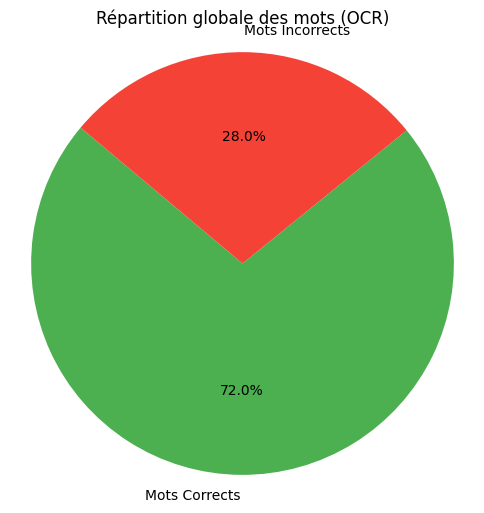

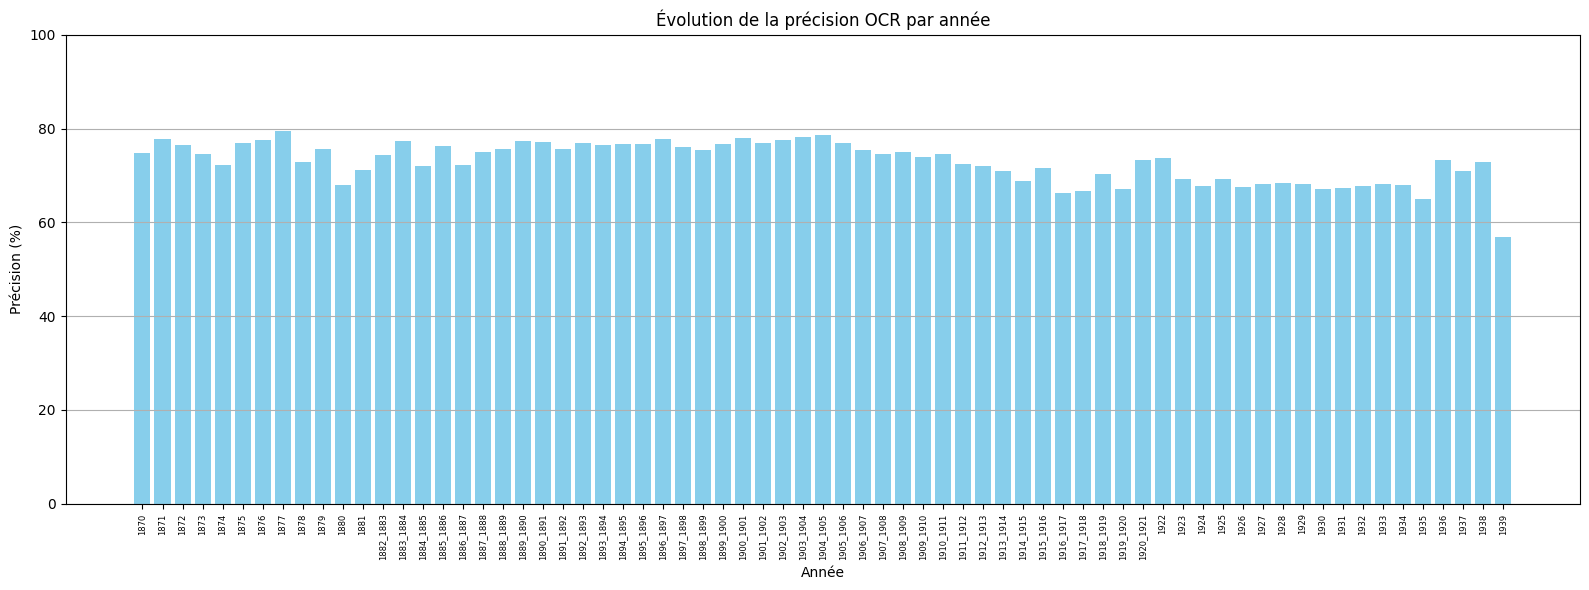

In [ ]:
def afficher_précision(df, dico_fr, dico_med, dico_prenoms) :
    precision_df = calculer_precision_OCR(df, dico_fr, dico_med, dico_prenoms)
    precision_df['Precision (%)'] = precision_df['Mots corrects'] / precision_df['Mots totaux'] * 100

    total_correct = precision_df.loc[precision_df['year'] == 'Total', 'Mots corrects'].values[0]
    total_words = precision_df.loc[precision_df['year'] == 'Total', 'Mots totaux'].values[0]
    total_incorrect = total_words - total_correct

    labels = ['Mots Corrects', 'Mots Incorrects']
    sizes = [total_correct, total_incorrect]
    colors = ['#4CAF50', '#F44336']

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Répartition globale des mots (OCR)')
    plt.axis('equal')  
    plt.show()

    precision_df_years_only = precision_df[precision_df['year'] != 'Total']

    plt.figure(figsize=(16,6))
    plt.bar(precision_df_years_only['year'], precision_df_years_only['Precision (%)'], color='skyblue')
    plt.title('Évolution de la précision OCR par année')
    plt.xlabel('Année')
    plt.ylabel('Précision (%)')
    plt.grid(axis='y')
    plt.xticks(rotation=90, fontsize=6)  
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return precision_df

df2 = afficher_précision(df1, dico_fr, dico_med, dico_prenoms)


100%|██████████| 24928/24928 [01:18<00:00, 315.68it/s]


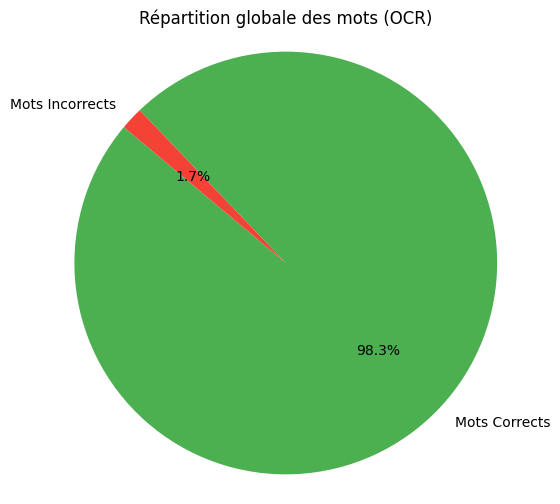

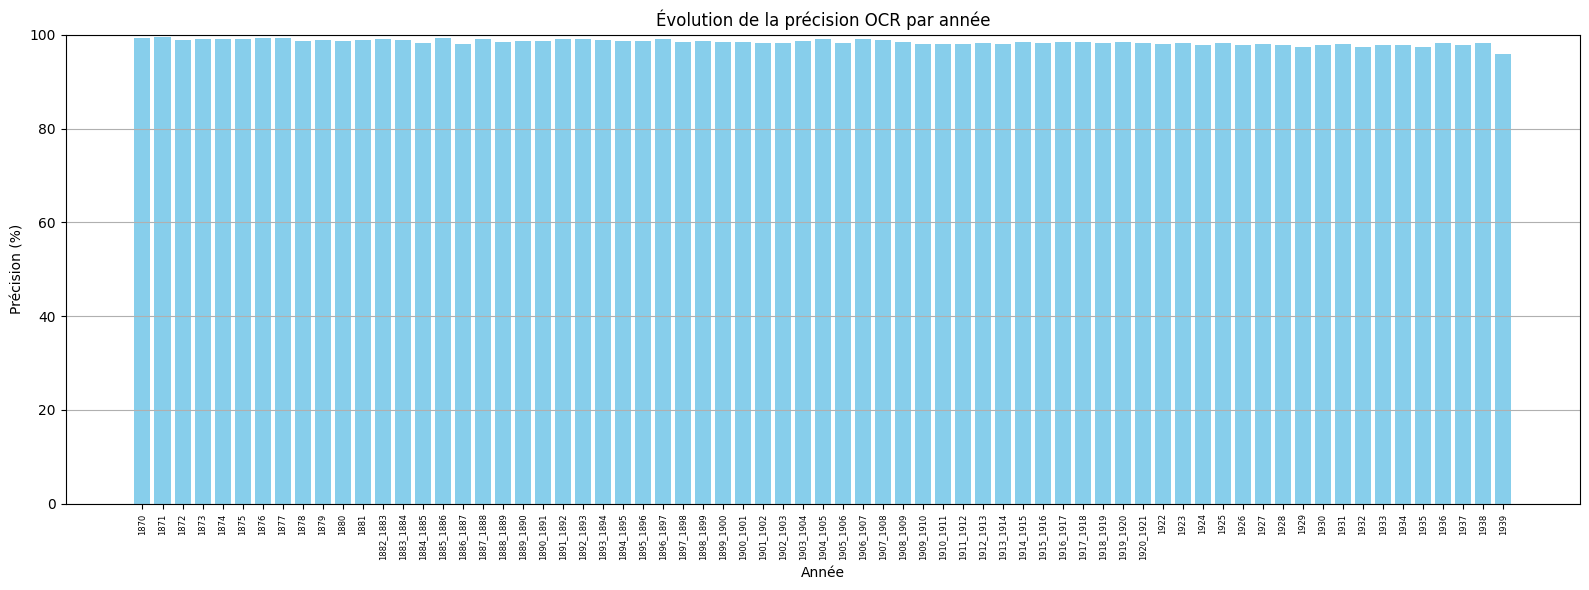

In [98]:
def preprocess(text):
    text = unidecode.unidecode(text.lower()) 
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ' -]", ' ', text)  
    return text.strip()

def correct_token(token, vocab, threshold=85):
    if token in vocab:
        return token
    match = rapidfuzz.process.extractOne(token, vocab, score_cutoff=threshold)
    if match:
        return match[0]  # match is (match_string, score, index)
    return token  

def correct_ocr_text(text, vocab):
    text = preprocess(text)
    tokens = text.split()
    corrected_tokens = [correct_token(t, vocab) for t in tokens]
    return ' '.join(corrected_tokens)

tqdm.tqdm.pandas()  
df3 = df1.copy()
df3['Sujet'] = df1['Sujet'].progress_apply(lambda x: correct_ocr_text(x, set(dico_fr) | set(dico_med)))

df3['Prénom'] = df1['Prénom'].progress_apply(lambda x: correct_ocr_text(x,set(dico_prenoms)))

df4 = afficher_précision(df3, dico_fr, dico_med, dico_prenoms)





RECONNAISSANCE DU SEXE (DICTIONNAIRE DES PRENOMS) 

In [ ]:
input_dir = input_dir = os.path.join(current_dir, '..', 'data', 'Dictionnaires')  # Relative path to 'lib/data/pdfs_en_images_png'

df_prenoms = pd.read_csv(os.path.join(input_dir, 'Prenoms.csv'), sep=";", header=None, names=["Prénom", "genre", "langue", "frequence"], encoding='ISO-8859-1')

dictionnaire_prenoms = dict(zip(df_prenoms['Prénom'], df_prenoms['genre']))

def detect_genre(prenom):
    if not isinstance(prenom, str):
        return "Inconnu"

    prenom_clean = remove_accents(prenom).lower()
    composants = re.split(r'[-\s]', prenom_clean)

    genres_detectes = set()
    for comp in composants:
        genre = dictionnaire_prenoms.get(comp)
        if genre:
            genres_detectes.update(genre.split(','))

    if not genres_detectes:
        return 'Inconnu'
    
    if genres_detectes == {'m'}:
        return 'm'
    elif genres_detectes == {'f'}:
        return 'f'
    elif 'm' in genres_detectes and 'f' not in genres_detectes:
        return 'm'
    elif 'f' in genres_detectes and 'm' not in genres_detectes:
        return 'f'
    elif 'm' in genres_detectes and 'f' in genres_detectes:
        return 'm' 
    else:
        return 'Inconnu'



df3['Prénom'] = df3['Prénom'].apply(remove_accents).str.lower()

df3['genre'] = df3['Prénom'].apply(detect_genre)




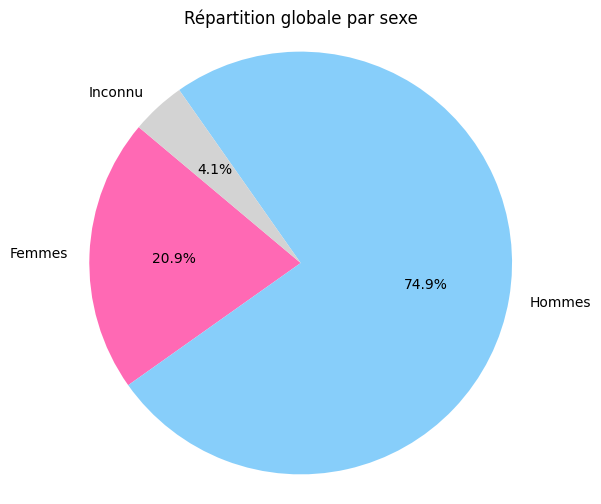

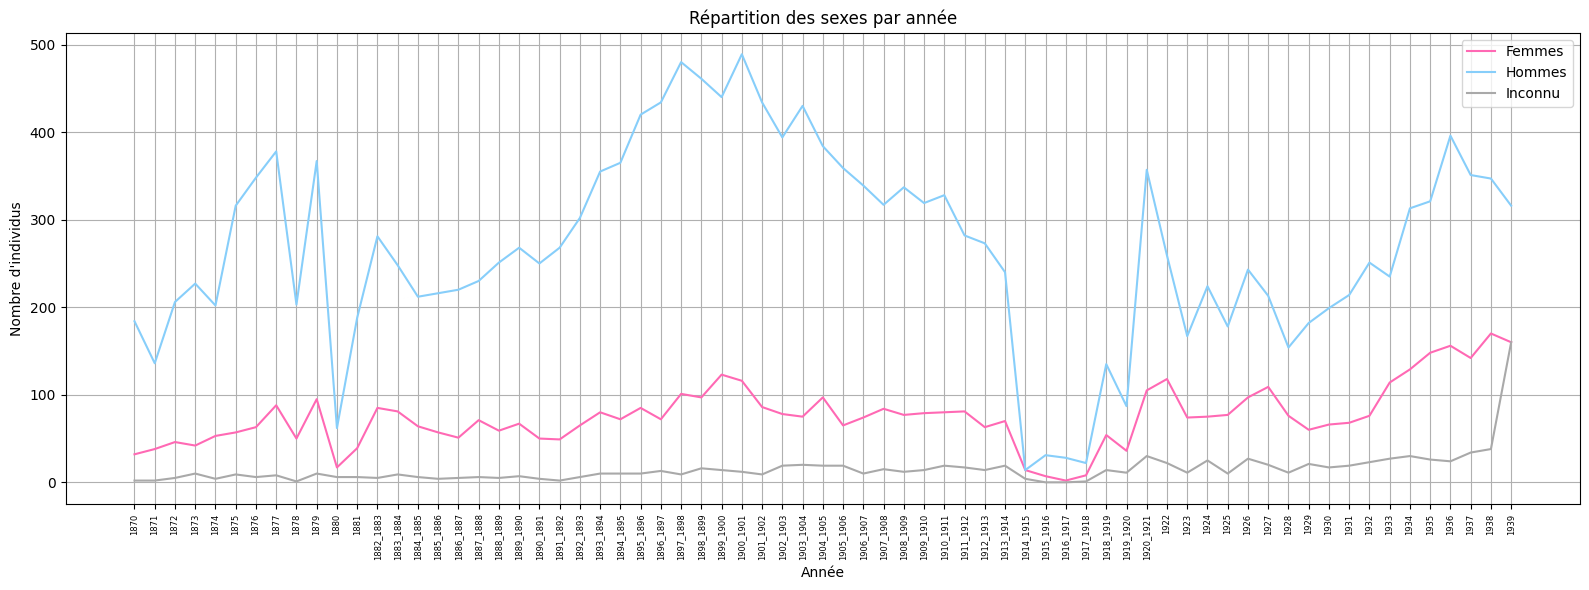

In [ ]:
def calculer_genres_par_annee(df):
    df_genre = df.groupby(['year', 'genre']).size().unstack(fill_value=0).reset_index()

    for genre in ['f', 'm', 'Inconnu']:
        if genre not in df_genre.columns:
            df_genre[genre] = 0

    total_row = pd.DataFrame({
        'year': ['Total'],
        'f': [df_genre['f'].sum()],
        'm': [df_genre['m'].sum()],
        'Inconnu': [df_genre['Inconnu'].sum()]
    })

    df_genre = pd.concat([df_genre, total_row], ignore_index=True)

    return df_genre

def afficher_genres_par_annee(df):
    genre_df = calculer_genres_par_annee(df)

    total = genre_df[genre_df['year'] == 'Total']
    sizes = [total['f'].values[0], total['m'].values[0], total['Inconnu'].values[0]]
    labels = ['Femmes', 'Hommes', 'Inconnu']
    colors = ['#FF69B4', '#87CEFA', '#D3D3D3']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition globale par sexe")
    plt.axis("equal")
    plt.show()

    genre_df_years_only = genre_df[genre_df['year'] != 'Total']

    plt.figure(figsize=(16, 6))
    plt.plot(genre_df_years_only['year'], genre_df_years_only['f'], label='Femmes', color='#FF69B4')
    plt.plot(genre_df_years_only['year'], genre_df_years_only['m'], label='Hommes', color='#87CEFA')
    plt.plot(genre_df_years_only['year'], genre_df_years_only['Inconnu'], label='Inconnu', color='#A9A9A9')
    plt.legend()
    plt.title("Répartition des sexes par année")
    plt.xlabel("Année")
    plt.ylabel("Nombre d'individus")
    plt.xticks(rotation=90, fontsize=6)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return genre_df

df_genre = afficher_genres_par_annee(df3)


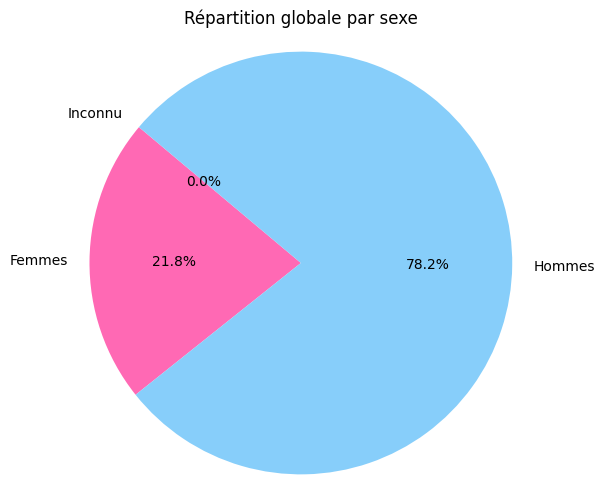

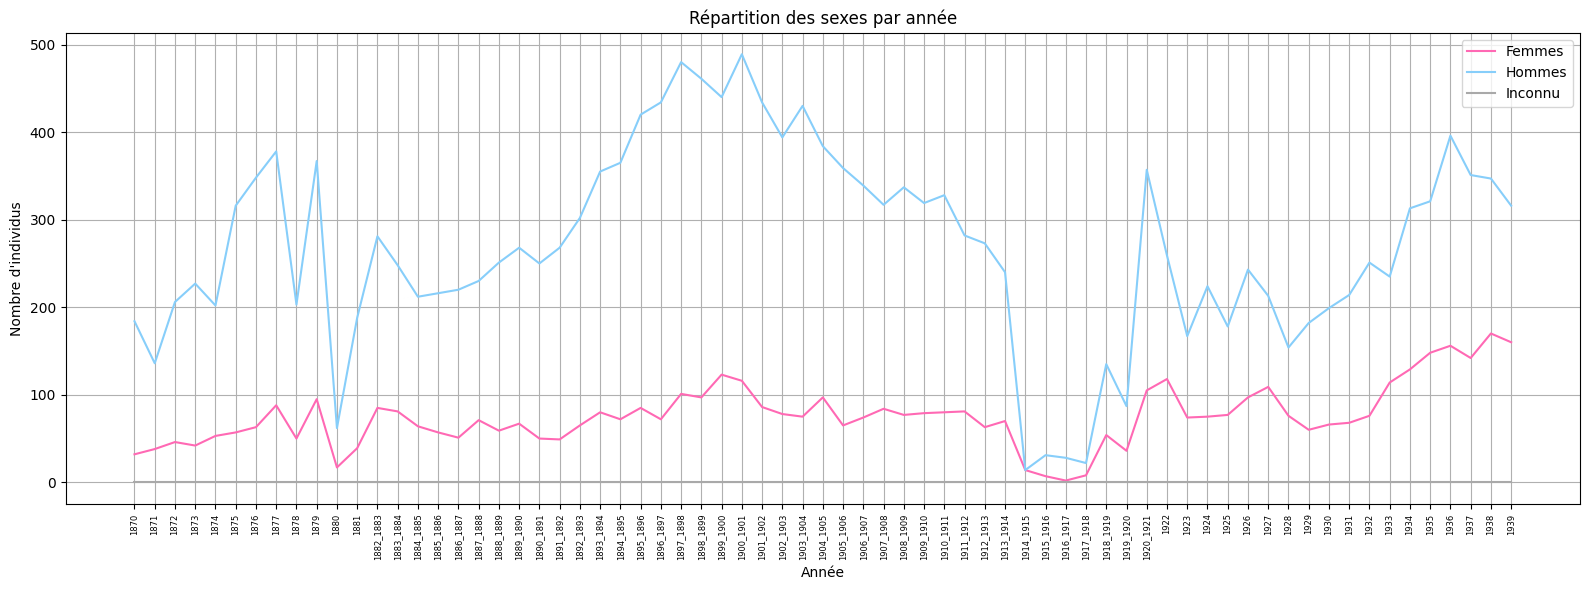

In [101]:
df3 = df3[df3['genre'] != 'Inconnu'].copy()
df_genre = afficher_genres_par_annee(df3)

ANALYSE THEMATIQUE 

📊 Pourcentage de sujets non classifiables : 47.8%


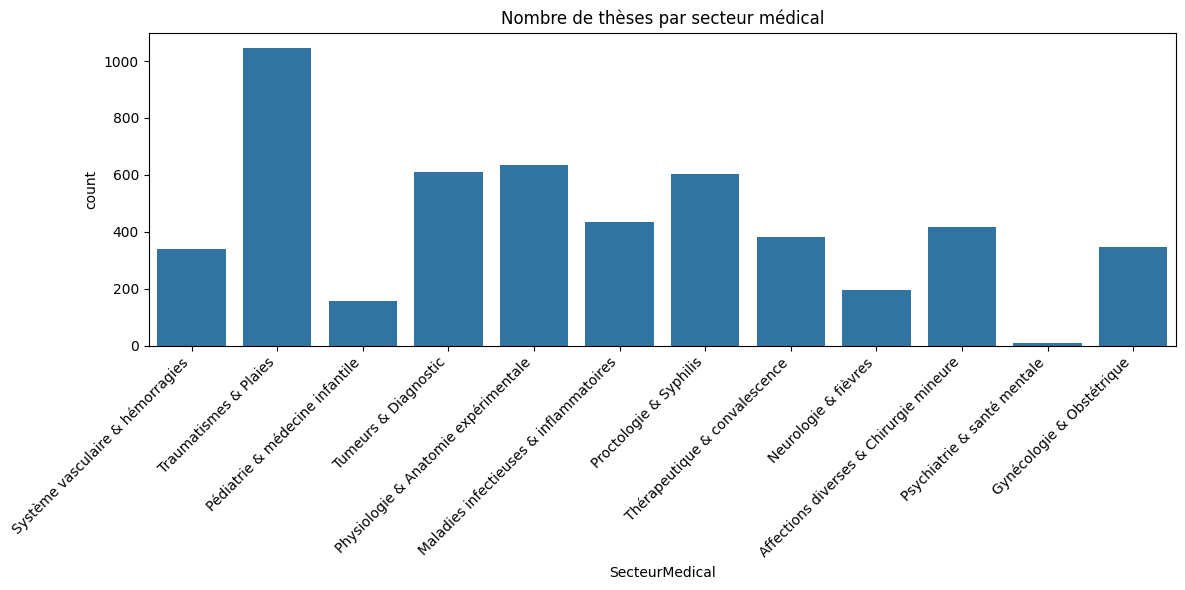

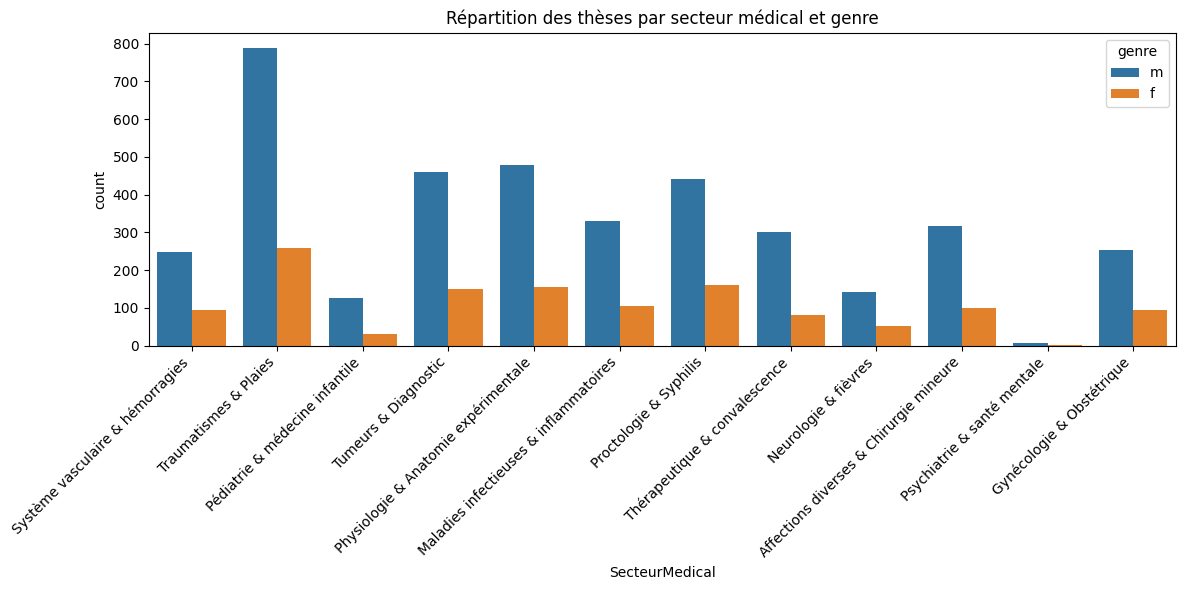

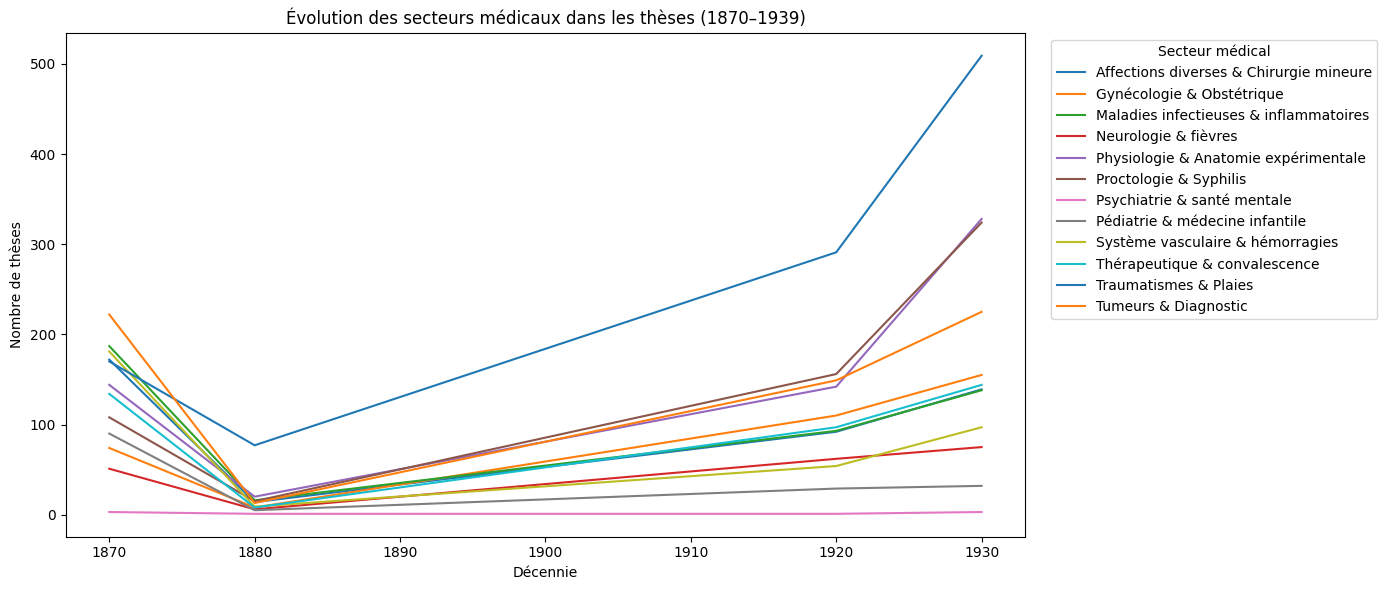

In [ ]:
mots_bruits = {"gri", "gri gri", "vouvoyassions", "obium", "bium", "tome", "men", "page", "numeros", "na", "ri", "amp"}
corrections = {"foi": "foie", "frigorie": "fievre", "null": "", "nul": "", "coches": "coeur"}

def nettoyer_ocr(text):
    t = str(text).lower()
    t = re.sub(r"[^\w\s]", " ", t)
    mots = [corrections.get(m, m) for m in t.split() if m not in mots_bruits]
    return " ".join(mots)

df3["Sujet_clean_bert"] = df3["Sujet"].apply(nettoyer_ocr)

df3 = df3[pd.to_numeric(df3["year"], errors="coerce").between(1870, 1939)].copy()
df3["year"] = df3["year"].astype(int)
df3["Décennie"] = (df3["year"] // 10) * 10


model = SentenceTransformer('distiluse-base-multilingual-cased')
embeddings = model.encode(df3["Sujet_clean_bert"].tolist())
kmeans = KMeans(n_clusters=12, random_state=0)
df3["Theme_BERT"] = kmeans.fit_predict(embeddings)

racines_medicales = [
    "syphilit", "tuberculeux", "puerperal", "infectie", "fiévreux", "chirurgic",
    "typhique", "tubercul", "syphil", "pleur", "typh", "mening", "gripp", "bronch", "pneumo",
    "rhumat", "hemorrag", "ulcer", "tum", "cancer", "gangren", "nephr", "eczema", "asthme",
    "chirurg", "obstetr", "gyneco", "psychi", "neuro", "ophtalm", "orthoped", "anat", "pathol",
    "physiol", "therap", "pediatr", "geriatr", "cardio", "uro", "dermat", "oncolog", "infect",
    "plèvre", "moelle", "cerve", "rein", "foie", "coeur", "estomac", "intestin", "vessie", "poumon",
    "uterus", "ovaire", "colon", "larynx", "nerf", "thyroid", "os", "peau", "rate", "sang", "urine",
    "pus", "accouche", "grossess", "paralys", "fract", "plaie", "amput", "obstr", "fièv",
    "diagnos", "pronost", "symptom", "syndrom", "anomal", "affect", "lesion", "obser"
]

def contient_terme_medical(sujet):
    mots = sujet.lower().split()
    return any(any(m.startswith(root) for root in racines_medicales) for m in mots)

df3["Longueur"] = df3["Sujet_clean_bert"].apply(lambda s: len(s.split()))
df3["NonClassifiable"] = (df3["Longueur"] < 4) | (~df3["Sujet_clean_bert"].apply(contient_terme_medical))
print(f"📊 Pourcentage de sujets non classifiables : {df3['NonClassifiable'].mean() * 100:.1f}%")

theme_labels = {
    0: "Maladies infectieuses & inflammatoires",
    1: "Gynécologie & Obstétrique",
    2: "Thérapeutique & convalescence",
    3: "Neurologie & fièvres",
    4: "Système vasculaire & hémorragies",
    5: "Physiologie & Anatomie expérimentale",
    6: "Tumeurs & Diagnostic",
    7: "Traumatismes & Plaies",
    8: "Affections diverses & Chirurgie mineure",
    9: "Proctologie & Syphilis",
    10: "Psychiatrie & santé mentale",
    11: "Pédiatrie & médecine infantile"
}
df3["SecteurMedical"] = df3["Theme_BERT"].map(theme_labels)


plt.figure(figsize=(12, 6))
sns.countplot(
    data=df3[~df3["NonClassifiable"]],
    x="SecteurMedical",
    order=df3["SecteurMedical"].value_counts().index
)
plt.title("Nombre de thèses par secteur médical")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df3[~df3["NonClassifiable"]],
    x="SecteurMedical",
    hue="genre",
    order=df3["SecteurMedical"].value_counts().index
)
plt.title("Répartition des thèses par secteur médical et genre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pivot = df3[~df3["NonClassifiable"]].pivot_table(
    index="Décennie",
    columns="SecteurMedical",
    aggfunc="size",
    fill_value=0
)
pivot = pivot.sort_index()  
pivot.plot(figsize=(14, 6))
plt.title("Évolution des secteurs médicaux dans les thèses (1870–1939)")
plt.ylabel("Nombre de thèses")
plt.xlabel("Décennie")
plt.legend(title="Secteur médical", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

os.makedirs("../data", exist_ok=True)
df3.to_excel("../data/theses_paris_1870_1939_bert_clusters.xlsx", index=False)

